In [1]:
import os
from dataclasses import dataclass, field
from typing import Any, Generator, Optional, Tuple, Union

import numpy as np
import torch
from torchtyping import TensorType
import tqdm

In [2]:
n_ground_truth_components_, activation_dim_, dataset_size_ = (
    None,
    None,
    None,
) # type: Tuple[None, None, None]


@dataclass
class RandomDatasetGenerator(Generator):
    activation_dim: int
    n_ground_truth_components: int
    batch_size: int
    feature_num_nonzero: int
    feature_prob_decay: float
    correlated: bool
    device: Union[torch.device, str]

    frac_nonzero: float = field(init=False)
    decay: TensorType["n_ground_truth_components"] = field(init=False)
    feats: TensorType["n_ground_truth_components", "activation_dim"] = field(init=False)
    corr_matrix: Optional[TensorType["n_ground_truth_components", "n_ground_truth_components"]] = field(init=False)
    component_probs: Optional[TensorType["n_ground_truth_components"]] = field(init=False)

    def __post_init__(self):
        self.frac_nonzero = self.feature_num_nonzero / self.n_ground_truth_components

        # Define the probabilities of each component being included in the data
        self.decay = torch.tensor([self.feature_prob_decay**i for i in range(self.n_ground_truth_components)]).to(
            self.device
        )  # FIXME: 1 / i

        if self.correlated:
            self.corr_matrix = generate_corr_matrix(self.n_ground_truth_components, device=self.device)
        else:
            self.component_probs = self.decay * self.frac_nonzero  # Only if non-correlated
        self.feats = generate_rand_feats(
            self.activation_dim,
            self.n_ground_truth_components,
            device=self.device,
        )
        self.t_type = torch.float32

    def send(self, ignored_arg: Any) -> TensorType["dataset_size_", "activation_dim_"]:
        if self.correlated:
            _, _, data = generate_correlated_dataset(
                self.n_ground_truth_components,
                self.batch_size,
                self.corr_matrix,
                self.feats,
                self.frac_nonzero,
                self.decay,
                self.device,
            )
        else:
            _, _, data = generate_rand_dataset(
                self.n_ground_truth_components,
                self.batch_size,
                self.component_probs,
                self.feats,
                self.device,
            )
        return data.to(self.t_type)

    def throw(self, type: Any = None, value: Any = None, traceback: Any = None) -> None:
        raise StopIteration

def generate_rand_dataset(
    n_ground_truth_components: int,  #
    dataset_size: int,
    feature_probs: TensorType["n_ground_truth_components_"],
    feats: TensorType["n_ground_truth_components_", "activation_dim_"],
    device: Union[torch.device, str],
) -> Tuple[
    TensorType["n_ground_truth_components_", "activation_dim_"],
    TensorType["dataset_size_", "n_ground_truth_components_"],
    TensorType["dataset_size_", "activation_dim_"],
]:
    dataset_thresh = torch.rand(dataset_size, n_ground_truth_components, device=device)
    dataset_values = torch.rand(dataset_size, n_ground_truth_components, device=device)

    data_zero = torch.zeros_like(dataset_thresh, device=device)

    dataset_codes = torch.where(
        dataset_thresh <= feature_probs,
        dataset_values,
        data_zero,
    )  # dim: dataset_size x n_ground_truth_components

    # Multiply by a 2D random matrix of feature strengths
    feature_strengths = torch.rand((dataset_size, n_ground_truth_components), device=device)
    dataset = (dataset_codes * feature_strengths) @ feats

    # dataset = dataset_codes @ feats

    return feats, dataset_codes, dataset


def generate_correlated_dataset(
    n_ground_truth_components: int,
    dataset_size: int,
    corr_matrix: TensorType["n_ground_truth_components_", "n_ground_truth_components_"],
    feats: TensorType["n_ground_truth_components_", "activation_dim_"],
    frac_nonzero: float,
    decay: TensorType["n_ground_truth_components_"],
    device: Union[torch.device, str],
) -> Tuple[
    TensorType["n_ground_truth_components_", "activation_dim_"],
    TensorType["dataset_size_", "n_ground_truth_components_"],
    TensorType["dataset_size_", "activation_dim_"],
]:
    # Get a correlated gaussian sample
    mvn = torch.distributions.MultivariateNormal(
        loc=torch.zeros(n_ground_truth_components, device=device),
        covariance_matrix=corr_matrix,
    )
    corr_thresh = mvn.sample()

    # Take the CDF of that sample.
    normal = torch.distributions.Normal(torch.tensor([0.0], device=device), torch.tensor([1.0], device=device))
    cdf = normal.cdf(corr_thresh.squeeze())

    # Decay it
    component_probs = cdf * decay

    # Scale it to get the right % of nonzeros
    mean_prob = torch.mean(component_probs)
    scaler = frac_nonzero / mean_prob
    component_probs *= scaler
    # So np.isclose(np.mean(component_probs), frac_nonzero) will be True

    # Generate sparse correlated codes
    dataset_thresh = torch.rand(dataset_size, n_ground_truth_components, device=device)
    dataset_values = torch.rand(dataset_size, n_ground_truth_components, device=device)

    data_zero = torch.zeros_like(corr_thresh, device=device)
    dataset_codes = torch.where(
        dataset_thresh <= component_probs,
        dataset_values,
        data_zero,
    )
    # Ensure there are no datapoints w/ 0 features
    zero_sample_index = (dataset_codes.count_nonzero(dim=1) == 0).nonzero()[:, 0]
    random_index = torch.randint(low=0, high=n_ground_truth_components, size=(zero_sample_index.shape[0],)).to(
        dataset_codes.device
    )
    dataset_codes[zero_sample_index, random_index] = 1.0

    # Multiply by a 2D random matrix of feature strengths
    feature_strengths = torch.rand((dataset_size, n_ground_truth_components), device=device)
    dataset = (dataset_codes * feature_strengths) @ feats

    return feats, dataset_codes, dataset


def generate_rand_feats(
    feat_dim: int,
    num_feats: int,
    device: Union[torch.device, str],
) -> TensorType["n_ground_truth_components_", "activation_dim_"]:
    data_path = os.path.join(os.getcwd(), "data")
    data_filename = os.path.join(data_path, f"feats_{feat_dim}_{num_feats}.npy")

    feats = np.random.multivariate_normal(np.zeros(feat_dim), np.eye(feat_dim), size=num_feats)
    feats = feats.T / np.linalg.norm(feats, axis=1)
    feats = feats.T

    feats_tensor = torch.from_numpy(feats).to(device).float()
    return feats_tensor


def generate_corr_matrix(
    num_feats: int, device: Union[torch.device, str]
) -> TensorType["n_ground_truth_components_", "n_ground_truth_components_"]:
    corr_mat_path = os.path.join(os.getcwd(), "data")
    corr_mat_filename = os.path.join(corr_mat_path, f"corr_mat_{num_feats}.npy")

    # Create a correlation matrix
    corr_matrix = np.random.rand(num_feats, num_feats)
    corr_matrix = (corr_matrix + corr_matrix.T) / 2
    min_eig = np.min(np.real(np.linalg.eigvals(corr_matrix)))
    if min_eig < 0:
        corr_matrix -= 1.001 * min_eig * np.eye(corr_matrix.shape[0], corr_matrix.shape[1])

    corr_matrix_tensor = torch.from_numpy(corr_matrix).to(device).float()

    return corr_matrix_tensor

In [3]:
def normalize_dict(m):
    norms = torch.norm(m, p=2, dim=-1, keepdim=True)
    return m / norms

class BasicSAE(torch.nn.Module):
    def __init__(self, d_in, d_hidden, alpha):
        super().__init__()
        initial_matrix = torch.randn(d_hidden, d_in)
        initial_matrix = normalize_dict(initial_matrix)
        self.embed = torch.nn.Parameter(initial_matrix.clone())
        self.unembed = torch.nn.Parameter(initial_matrix.clone())
        self.embed_bias = torch.nn.Parameter(torch.zeros(d_hidden))
        self.unembed_bias = torch.nn.Parameter(torch.zeros(d_in))

        self.alpha = alpha
    
    def forward(self, x):
        h = torch.einsum('ij,bj->bi', self.embed, x) + self.embed_bias.unsqueeze(0)
        h = torch.nn.functional.relu(h)
        x_hat = torch.einsum('ij,bi->bj', normalize_dict(self.unembed), h) + self.unembed_bias.unsqueeze(0)

        mse = torch.nn.functional.mse_loss(x_hat, x, reduction='mean')
        sparsity = torch.nn.functional.l1_loss(h, torch.zeros_like(h), reduction='mean') * self.alpha

        return mse + sparsity, h, x_hat

In [4]:
l1_alphas = np.logspace(-2, 1, 100)
n_feats = 1024
d_model = 256
device = "cuda:0"

generator = RandomDatasetGenerator(
    activation_dim=d_model,
    n_ground_truth_components=n_feats,
    batch_size=1024,
    feature_num_nonzero=10,
    feature_prob_decay=0.998, # final feat has 10% the probability of the first
    correlated=True,
    device=device,
)

In [5]:
from matplotlib import pyplot as plt

def calc_mean_max_cosine_similarity(model, generator):
    model_feat_dict = normalize_dict(model.unembed)
    data_feat_dict = normalize_dict(generator.feats)

    cosines = torch.einsum('ij,kj->ik', model_feat_dict, data_feat_dict)
    max_cosines = cosines.max(dim=-1).values
    return max_cosines.mean().item()

def get_metrics(models, generator, n_iters=10):
    data_mean_mse = 0
    model_mean_mse = [0 for _ in models]
    model_sparsity = [0 for _ in models]
    model_mmcs = [calc_mean_max_cosine_similarity(model, generator) for model in models]

    for _ in range(n_iters):
        data = generator.send(None)

        batch_mean = torch.mean(data, dim=0)

        data_mean_mse += torch.nn.functional.mse_loss(data, batch_mean.unsqueeze(0), reduction='mean').item()

        for i, model in enumerate(models):
            with torch.no_grad():
                _, h, x_hat = model(data)
                model_mean_mse[i] += torch.nn.functional.mse_loss(data, x_hat, reduction='mean').item()
                model_sparsity[i] += (h > 0).float().sum(dim=-1).mean().item()
    
    data_mean_mse /= n_iters
    model_mean_mse = [m / n_iters for m in model_mean_mse]
    model_sparsity = [s / n_iters for s in model_sparsity]

    model_scaled_mse = [m / data_mean_mse for m in model_mean_mse]

    return model_scaled_mse, model_sparsity, model_mmcs

def plot_ensemble(model_scaled_mse, model_sparsity, model_mmcs):
    plt.scatter(model_sparsity, model_scaled_mse, c=model_mmcs, cmap='viridis')
    plt.xlabel('Sparsity')
    plt.ylabel('Scaled MSE')
    plt.colorbar(label='Mean Max Cosine Similarity')
    plt.show()

  0%|          | 0/10000 [00:00<?, ?it/s]/tmp/ipykernel_24242/1871433150.py:22: UserWarning: Using a target size (torch.Size([1, 256])) that is different to the input size (torch.Size([1024, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  data_mean_mse += torch.nn.functional.mse_loss(data, batch_mean.unsqueeze(0), reduction='mean').item()


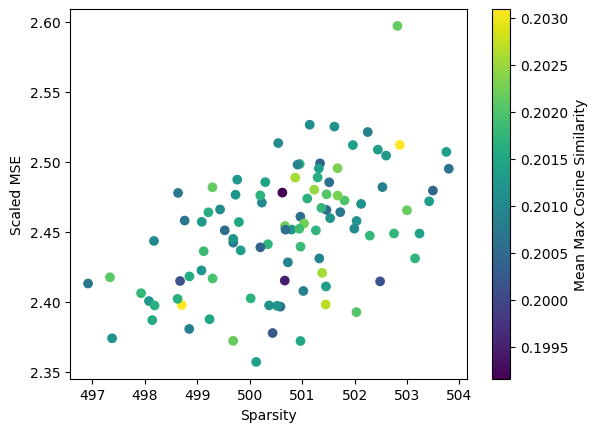

 50%|█████     | 5000/10000 [17:43<19:33,  4.26it/s]

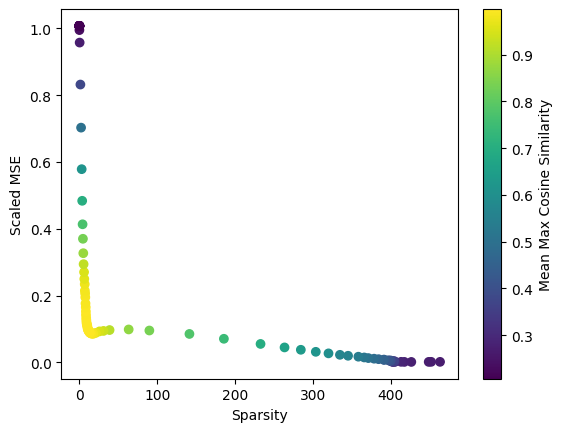

100%|██████████| 10000/10000 [33:59<00:00,  4.90it/s]


In [6]:
models = [
    BasicSAE(d_model, n_feats, alpha).to(device)
    for alpha in l1_alphas
]

optimizers = [
    torch.optim.Adam(model.parameters(), lr=1e-3)
    for model in models
]

num_steps = 10_000

metrics = []

for step in tqdm.tqdm(range(num_steps)):
    data = generator.send(None)

    for model, optimizer in zip(models, optimizers):
        optimizer.zero_grad()
        loss, _, _ = model(data)
        loss.backward()
        optimizer.step()

    if step % 5_000 == 4999:
        model_scaled_mse, model_sparsity, model_mmcs = get_metrics(models, generator)
        metrics.append({"scaled_mse": model_scaled_mse, "sparsity": model_sparsity, "mmcs": model_mmcs})
        plot_ensemble(model_scaled_mse, model_sparsity, model_mmcs)